In [1]:
# import library
import matplotlib
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
import pyLDAvis
import pyLDAvis.gensim_models 


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zacha\anaconda3\envs\UP229\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zacha\anaconda3\envs\UP229\lib\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# bring in the CSV and take a look at it
df_filtered = pd.read_csv('data/join_list_exclusive.csv')
df_filtered.head(10)

,id,listing_url,scrape_id,last_scraped,name_left,description,neighborhood_overview,picture_url,host_id,host_url,...,latitude_right,location,longitude_right,name_right,name_1,set,slug,slug_1,sqmi,type
0,33447,https://www.airbnb.com/rooms/33447,20210207181900,2021-02-09,Malibu Guest house/ near beach,"<b>The space</b><br />Little, mid century, ran...",".2 of Mi to Little Dume Beach, <br />one mile ...",https://a0.muscache.com/pictures/343136/f46907...,144837,https://www.airbnb.com/users/show/144837,...,-118.754254,POINT(34.033895486545326 -118.7542537868066),34.033895,Malibu,NaN,L.A. County Neighborhoods (Current),malibu,NaN,19.886331,standalone-city
1,47537,https://www.airbnb.com/rooms/47537,20210207181900,2021-02-09,Malibu Ocean View Rooms for Rent 3,This ocean view room 80 yards from the Pacific...,NaN,https://a0.muscache.com/pictures/941bcb3d-4a6f...,215462,https://www.airbnb.com/users/show/215462,...,-118.754254,POINT(34.033895486545326 -118.7542537868066),34.033895,Malibu,NaN,L.A. County Neighborhoods (Current),malibu,NaN,19.886331,standalone-city
2,172193,https://www.airbnb.com/rooms/172193,20210207181900,2021-02-10,Spend your Holidays in Magnificent Malibu,"Elegant Rendition's Available<br />Happy, Heal...",NaN,https://a0.muscache.com/pictures/3375102/22659...,821698,https://www.airbnb.com/users/show/821698,...,-118.754254,POINT(34.033895486545326 -118.7542537868066),34.033895,Malibu,NaN,L.A. County Neighborhoods (Current),malibu,NaN,19.886331,standalone-city
3,187526,https://www.airbnb.com/rooms/187526,20210207181900,2021-02-09,Malibu Pacific Ocean View Room 1,<b>The space</b><br />5 Star Reviews by 650 gu...,NaN,https://a0.muscache.com/pictures/8b501535-2d64...,215462,https://www.airbnb.com/users/show/215462,...,-118.754254,POINT(34.033895486545326 -118.7542537868066),34.033895,Malibu,NaN,L.A. County Neighborhoods (Current),malibu,NaN,19.886331,standalone-city
4,218672,https://www.airbnb.com/rooms/218672,20210207181900,2021-02-09,Beautiful Ocean Front Beach House D,A beautiful 2-bedroom Malibu beach house on a ...,NaN,https://a0.muscache.com/pictures/4023537/dc784...,465624,https://www.airbnb.com/users/show/465624,...,-118.754254,POINT(34.033895486545326 -118.7542537868066),34.033895,Malibu,NaN,L.A. County Neighborhoods (Current),malibu,NaN,19.886331,standalone-city
5,287339,https://www.airbnb.com/rooms/287339,20210207181900,2021-02-09,Dog Friendly 3BD Home on PRIVATE beach in Malibu,There is probably no better way to escape and ...,Malibu is one of the hottest areas to visit in...,https://a0.muscache.com/pictures/42691726/a0f8...,1494781,https://www.airbnb.com/users/show/1494781,...,-118.754254,POINT(34.033895486545326 -118.7542537868066),34.033895,Malibu,NaN,L.A. County Neighborhoods (Current),malibu,NaN,19.886331,standalone-city
6,421431,https://www.airbnb.com/rooms/421431,20210207181900,2021-02-10,Broad Beach Cape Cod,"<b>The space</b><br />Beautiful, fully remodel...",NaN,https://a0.muscache.com/pictures/56508122/af03...,2095936,https://www.airbnb.com/users/show/2095936,...,-118.754254,POINT(34.033895486545326 -118.7542537868066),34.033895,Malibu,NaN,L.A. County Neighborhoods (Current),malibu,NaN,19.886331,standalone-city
7,518815,https://www.airbnb.com/rooms/518815,20210207181900,2021-02-09,Ocean View Room in Malibu 2,This ocean view room 80 yards from the Pacific...,NaN,https://a0.muscache.com/pictures/015bb30b-346e...,215462,https://www.airbnb.com/users/show/215462,...,-118.754254,POINT(34.033895486545326 -118.7542537868066),34.033895,Malibu,NaN,L.A. County Neighborhoods (Current),malibu,NaN,19.886331,standalone-city
8,939688,https://www.airbnb.com/rooms/939688,20210207181900,2021-02-09,Malibu Beachfront Penthouse,Our luxury beach front Malibu penthouse is the...,The Malibu property has unprecedented privacy ...,https://a0.muscache.com/pictures/69778546/0a1d...,5076940,https://www.airbnb.com/users/show/5076940,...,-118.754254,POINT(34.033895486545326 -118.7542537868066),34.033895,Malibu,NaN,L.A. County Neighbor

In [3]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159 entries, 0 to 1158
Data columns (total 89 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            1159 non-null   int64  
 1   listing_url                                   1159 non-null   object 
 2   scrape_id                                     1159 non-null   int64  
 3   last_scraped                                  1159 non-null   object 
 4   name_left                                     1159 non-null   object 
 5   description                                   1116 non-null   object 
 6   neighborhood_overview                         781 non-null    object 
 7   picture_url                                   1159 non-null   object 
 8   host_id                                       1159 non-null   int64  
 9   host_url                                      1159 non-null   o

In [30]:
def clean_string(text):
    
    # convert to lower case to catch weird capitalization issues
    text = text.lower()
    # replace whitespace
    text = re.sub(r"\s+", " ", text)
    # remove punctuation
    text_wordsonly = re.sub(r"[^A-z\s]", "", text)
    # remove whitespace again
    text_wordsonly = re.sub(r"\s+", " ", text_wordsonly)
    # split the words into a list and tokenize
    wordlist = text_wordsonly.split()
    # wordlist = word_tokenize(text_wordsonly)

    # https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist
    # https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

    # define the stop words and add our custom ones
    stop_words = nltk.corpus.stopwords.words('english')
    newStopWords = ['malibu','rolling hills','bel air','topanga','bel-air','brentwood','palos verdes','pacific palisades','westlake village','westlake','hidden hills','calabasas','minute','peninsula','la','los','br','nan','space','room','private','home','house','garage','access','kitchen','guest','bedroom','one','living','located','full','large','los angeles','neighborhood', 'miles', 'away', 'minutes', 'distance', 'area', 'city', 'street', 'studios', 'many', 'universal', 'within', 'angeles', 'milder', 'also', 'close', 'north', 'min','downtown','milesbr','around','lots','blvd','santa','monica','spacebbr','theb','bthe','bguest','beachbr','covebr','laxbr','kiss','plus','sits','pick','including','mile','mi','visit','guests','next','time','assured','casa','las','like','call','rejoice','less','more','include','etc','ask','angelesbr','big','way','oh','on','direct','directly','stay','fee','per','hour','daybr','cleaning','applies','well','dont','need','thing','come','made','unless','n','stixbr','end','highly','recommend','choose','somewhere','another','place','whether','feet','roads','other','get']
    stop_words.extend(newStopWords)
 
    # filter out the stop words and add them to a new list called filtered_words
    filtered_words = [w for w in wordlist if not w in stop_words] 
    filtered_words = [] 
    for w in wordlist: 
        if w not in stop_words: 
               filtered_words.append(w) 
                
    # assign the new filtered word list to our cleaned list 
    cleaned_list_of_words = filtered_words
    return cleaned_list_of_words

# do it once through to check

In [31]:
hoodinfo = df_filtered.neighborhood_overview.astype(str)

In [32]:
# clean the text
clean_listing = [clean_string(i) for i in hoodinfo]; clean_listing

#get rid of extra blanks
clean_listing = list(filter(None, clean_listing))

#take a look at it
clean_listing

[['little',
  'dume',
  'beach',
  'point',
  'dume',
  'westward',
  'zuma',
  'paradise',
  'pierbr',
  'nobubr',
  'monicabr',
  'studiosbr',
  'hollywoodbr',
  'international',
  'airport',
  'van',
  'nuys',
  'airport'],
 ['hottest',
  'areas',
  'california',
  'pacific',
  'ocean',
  'attractions',
  'possibilities',
  'activity',
  'adventure',
  'shopping',
  'touring',
  'relaxation',
  'endless',
  'south',
  'piermalibu',
  'country',
  'mart',
  'pier',
  'hours',
  'drive',
  'disneyland',
  'hours',
  'san',
  'diego',
  'legolandsan',
  'diego',
  'zoo',
  'number',
  'wonderful',
  'hiking',
  'biking',
  'trails',
  'parks',
  'horseback',
  'riding',
  'tours',
  'camping',
  'sites',
  'wine',
  'tastings'],
 ['property',
  'unprecedented',
  'privacy',
  'alone',
  'stretch',
  'famous',
  'pacific',
  'coast',
  'highway',
  'property',
  'added',
  'advantage',
  'short',
  'drive',
  'malibus',
  'award',
  'winning',
  'restaurants',
  'giving',
  'plenty',
  

In [33]:
dictionary = gensim.corpora.Dictionary(clean_listing)
corpus = [dictionary.doc2bow(wl) for wl in clean_listing]
model = gensim.models.LdaMulticore(corpus, id2word=dictionary, num_topics=5, alpha = .01, eta=.01)

# alpha - similarity of words in the posts
# eta - similarity of words in topics?

model.show_topics()

[(0,
  '0.026*"beach" + 0.013*"restaurants" + 0.011*"drive" + 0.011*"pacific" + 0.010*"walking" + 0.010*"famous" + 0.009*"center" + 0.009*"hills" + 0.008*"getty" + 0.008*"community"'),
 (1,
  '0.025*"beach" + 0.012*"drive" + 0.010*"village" + 0.010*"walk" + 0.008*"shops" + 0.008*"restaurants" + 0.007*"pacific" + 0.007*"beautiful" + 0.007*"quiet" + 0.007*"walking"'),
 (2,
  '0.016*"beverly" + 0.016*"hills" + 0.015*"beach" + 0.011*"drive" + 0.010*"best" + 0.009*"park" + 0.009*"restaurants" + 0.008*"canyon" + 0.008*"beautiful" + 0.008*"walking"'),
 (3,
  '0.016*"quiet" + 0.013*"canyon" + 0.011*"hiking" + 0.011*"ocean" + 0.011*"trails" + 0.010*"beach" + 0.010*"drive" + 0.009*"restaurants" + 0.009*"walk" + 0.009*"pacific"'),
 (4,
  '0.022*"beach" + 0.021*"restaurants" + 0.015*"drive" + 0.014*"canyon" + 0.011*"walk" + 0.010*"palisades" + 0.009*"great" + 0.008*"shops" + 0.008*"shopping" + 0.008*"quiet"')]

In [34]:
model.show_topic(0)

[('beach', 0.026320387),
 ('restaurants', 0.013433135),
 ('drive', 0.010663207),
 ('pacific', 0.010556943),
 ('walking', 0.009648691),
 ('famous', 0.009593976),
 ('center', 0.008874786),
 ('hills', 0.008769546),
 ('getty', 0.00799588),
 ('community', 0.0075698574)]

In [35]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.007702 -0.033939       1        1  28.491419
0      0.030516  0.060916       2        1  22.814152
3      0.043830 -0.091892       3        1  20.380784
2      0.048705  0.060839       4        1  17.904948
1     -0.130752  0.004077       5        1  10.408697, topic_info=         Term        Freq       Total Category  logprob  loglift
1       beach  417.000000  417.000000  Default  30.0000  30.0000
250     hills  149.000000  149.000000  Default  29.0000  29.0000
656   beverly  134.000000  134.000000  Default  28.0000  28.0000
144     quiet  169.000000  169.000000  Default  27.0000  27.0000
1055  village  114.000000  114.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
61    beaches    9.958838   97.641230   Topic5  -5.3980  -0.0203
118     views    9.788118  103.628353   Topic5  -5.4153  -0.0971
65     center    9.775822  121.659262   Topic5  -5.4166  -0.2588
136     enjoy    8.737669   65.644605   Topic5  -5.5288   0.2459
127      safe    8.776371   70.527515   Topic5  -5.5244   0.1786

[464 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
501       1  0.906281   abbot
119       1  0.664538  across
119       2  0.086679  across
119       3  0.057786  across
119       4  0.028893  across
...     ...       ...     ...
633       1  0.189618   youre
633       2  0.113771   youre
633       3  0.227542   youre
633       4  0.455084   youre
1693      1  0.892267   youve

[796 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 3, 2])

# Try it out for each of the different columns of the filtered data

In [36]:
# do it for the neighborhood info
hoodinfo = df_filtered.neighborhood_overview.astype(str)
    
# clean the text
clean_listing = [clean_string(i) for i in hoodinfo]; clean_listing

#get rid of extra blanks
clean_listing = list(filter(None, clean_listing))

#set up the model
dictionary = gensim.corpora.Dictionary(clean_listing)
corpus = [dictionary.doc2bow(wl) for wl in clean_listing]
model = gensim.models.LdaMulticore(corpus, id2word=dictionary, num_topics=5, alpha = 1, eta=.01)

#make the charts
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.010159 -0.006909       1        1  23.147312
3     -0.004765  0.008824       2        1  22.482350
4      0.008627  0.003512       3        1  20.271943
0     -0.001509  0.001727       4        1  17.586009
2      0.007806 -0.007154       5        1  16.512385, topic_info=         Term        Freq       Total Category  logprob  loglift
26      drive  248.000000  248.000000  Default  30.0000  30.0000
133      walk  178.000000  178.000000  Default  29.0000  29.0000
1       beach  418.000000  418.000000  Default  28.0000  28.0000
65     center  121.000000  121.000000  Default  27.0000  27.0000
44   shopping  129.000000  129.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
38       pier   14.953111   99.438660   Topic5  -5.4530  -0.0936
128     shops   17.274550  139.516109   Topic5  -5.3087  -0.2879
36    pacific   18.006144  177.501354   Topic5  -5.2672  -0.4872
23    country   12.323172   68.109994   Topic5  -5.6465   0.0914
65     center   12.649395  121.205469   Topic5  -5.6203  -0.4588

[415 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2195      1  0.921735  abutting
2788      2  0.946565    africa
2305      2  0.951440   african
252       1  0.218844     along
252       2  0.246199     along
...     ...       ...       ...
1141      1  0.258081      yoga
1141      2  0.368687      yoga
1141      3  0.110606      yoga
1141      4  0.147475      yoga
1141      5  0.110606      yoga

[683 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 1, 3])

In [37]:
# do it for the title
listing_title = df_filtered.description.astype(str)
    
# clean the text
clean_listing = [clean_string(i) for i in listing_title]; clean_listing

#get rid of extra blanks
clean_listing = list(filter(None, clean_listing))

#set up the model
dictionary = gensim.corpora.Dictionary(clean_listing)
corpus = [dictionary.doc2bow(wl) for wl in clean_listing]
model = gensim.models.LdaMulticore(corpus, id2word=dictionary, num_topics=5, alpha = 1, eta=.01)

#make the charts
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.005170  0.006301       1        1  23.200053
3      0.001182 -0.001397       2        1  20.837157
1     -0.004777 -0.010106       3        1  20.620963
0      0.011382 -0.000031       4        1  19.774215
4     -0.002617  0.005233       5        1  15.567612, topic_info=         Term        Freq       Total Category  logprob  loglift
109      pool  369.000000  369.000000  Default  30.0000  30.0000
172     quiet  252.000000  252.000000  Default  29.0000  29.0000
430      unit  136.000000  136.000000  Default  28.0000  28.0000
389     views  613.000000  613.000000  Default  27.0000  27.0000
452     hills  233.000000  233.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
121    things   35.050651  216.320141   Topic5  -5.7623   0.0400
3    bathroom   41.718622  315.613080   Topic5  -5.5881  -0.1636
737    canyon   37.588682  262.976289   Topic5  -5.6924  -0.0854
309     enjoy   40.364123  391.238761   Topic5  -5.6212  -0.4114
618      walk   34.678408  226.884943   Topic5  -5.7730  -0.0183

[457 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3836      5  0.516249  aboundbr
76        1  0.111230  accepted
76        2  0.444920  accepted
76        3  0.111230  accepted
76        4  0.111230  accepted
...     ...       ...       ...
986       1  0.172699       yet
986       2  0.345399       yet
986       3  0.146130       yet
986       4  0.172699       yet
986       5  0.159415       yet

[923 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1, 5])

In [40]:
# do it for the description
description = df_filtered.description.astype(str)
    
# clean the text
clean_listing = [clean_string(i) for i in description]; clean_listing

#get rid of extra blanks
clean_listing = list(filter(None, clean_listing))

#set up the model
dictionary = gensim.corpora.Dictionary(clean_listing)
corpus = [dictionary.doc2bow(wl) for wl in clean_listing]
model = gensim.models.LdaMulticore(corpus, id2word=dictionary, num_topics=5, alpha = 1, eta=.01)

#make the charts
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.001903  0.005133       1        1  22.958309
1      0.006450 -0.008886       2        1  21.901559
3      0.006355  0.003344       3        1  21.863924
0     -0.010135 -0.005064       4        1  18.086706
2     -0.004572  0.005473       5        1  15.189502, topic_info=          Term        Freq       Total Category  logprob  loglift
4        beach  825.000000  825.000000  Default  30.0000  30.0000
2675   beverly  190.000000  190.000000  Default  29.0000  29.0000
3     bathroom  312.000000  312.000000  Default  28.0000  28.0000
105    pacific  249.000000  249.000000  Default  27.0000  27.0000
452      hills  233.000000  233.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
46        open   35.571124  252.972244   Topic5  -5.7230  -0.0772
633      drive   32.991076  215.847599   Topic5  -5.7983   0.0062
329    perfect   36.863137  287.192338   Topic5  -5.6873  -0.1684
206        bed   37.867328  376.496544   Topic5  -5.6604  -0.4123
30       great   33.605460  254.636827   Topic5  -5.7798  -0.1406

[441 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
477       1  0.198548  accessbbr
477       2  0.188098  accessbbr
477       3  0.233381  accessbbr
477       4  0.198548  accessbbr
477       5  0.181131  accessbbr
...     ...       ...        ...
660       1  0.256071      youll
660       2  0.196321      youll
660       3  0.213392      youll
660       4  0.119500      youll
660       5  0.221928      youll

[846 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 1, 3])

# Lets compare to the unfiltered data

In [41]:
# bring in the CSV and take a look at it
df_all = pd.read_csv('data/airbnb-listings.csv')
df_all.head(10)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,109,https://www.airbnb.com/rooms/109,20210207181900,2021-02-09,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",NaN,https://a0.muscache.com/pictures/4321499/1da98...,521,https://www.airbnb.com/users/show/521,...,8.0,10.0,8.0,NaN,f,1,1,0,0,0.02
1,2708,https://www.airbnb.com/rooms/2708,20210207181900,2021-02-09,Runyon Canyon | Beau Furn Mir Mini-Suite Fire...,Run Runyon Canyon<br /><br />Beautifully Furni...,"Walk and run to Runyon Canyon, it is open!<br ...",https://a0.muscache.com/pictures/miso/Hosting-...,3008,https://www.airbnb.com/users/show/3008,...,10.0,10.0,10.0,NaN,t,2,0,2,0,0.34
2,2732,https://www.airbnb.com/rooms/2732,20210207181900,2021-02-09,Zen Life at the Beach,An oasis of tranquility awaits you.<br /><br /...,"This is the best part of Santa Monica. Quiet, ...",https://a0.muscache.com/pictures/1082974/0f74c...,3041,https://www.airbnb.com/users/show/3041,...,9.0,10.0,9.0,228269,f,2,1,1,0,0.18
3,2864,https://www.airbnb.com/rooms/2864,20210207181900,2021-02-09,* Beautiful Master Suite/Jacuzzi Tub/*,Centrally located.... Furnished with King Size...,What makes the neighborhood unique is that the...,https://a0.muscache.com/pictures/23817858/de20...,3207,https://www.airbnb.com/users/show/3207,...,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN
4,5728,https://www.airbnb.com/rooms/5728,20210207181900,2021-02-10,Tiny Home in Artistic Oasis near Venice and LAX,Our home is located near Venice Beach without ...,Our neighborhood is very quiet and save. There...,https://a0.muscache.com/pictures/7a29d275-f293...,9171,https://www.airbnb.com/users/show/9171,...,10.0,10.0,9.0,NaN,f,4,1,3,0,2.20
5,5729,https://www.airbnb.com/rooms/5729,20210207181900,2021-02-09,Zen Room with Floating Bed near Venice and LAX,Our home is located near Venice Beach without ...,Our neighborhood is very quiet and save. There...,https://a0.muscache.com/pictures/f48e3ea8-2075...,9171,https://www.airbnb.com/users/show/9171,...,10.0,10.0,9.0,NaN,f,4,1,3,0,1.65
6,5843,https://www.airbnb.com/rooms/5843,20210207181900,2021-02-09,Artist Oasis near Venice Beach w/ Beautiful Ga...,Do you want a taste of Paradise?<br />Our one-...,Our neighborhood is very quiet and save. There...,https://a0.muscache.com/pictures/25d657aa-2529...,9171,https://www.airbnb.com/users/show/9171,...,10.0,10.0,9.0,HSR19-002149,f,4,1,3,0,1.08
7,6931,https://www.airbnb.com/rooms/6931,20210207181900,2021-02-09,Run Runyon | Beau Furn Rm Dres Rm/Wlk-In Clst...,"Run & Walk, Runyon Canyon is now open! <br />...",We are in the middle of one of the great citie...,https://a0.muscache.com/pictures/37075299/eb4b...,3008,https://www.airbnb.com/users/show/3008,...,10.0,10.0,9.0,NaN,t,2,0,2,0,0.17
8,7874,https://www.airbnb.com/rooms/7874,20210207181900,2021-02-09,Sunny and Private 2nd story Queen Bedroom,Upstairs Large bedroom with great natural ligh...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,21700,https://www.airbnb.com/users/show/21700,...,10.0,10.0,10.0,NaN,f,3,0,3,0,0.47
9,7992,https://www.airbnb.com/rooms/7992,20210207181900,2021-02-10,"Quiet,Walkable Area/Sanitized/CozySpot",Furnished apartment with a walk score of 77 in...,Atwater Village has a variety of great shops a...,https://a0.muscache.com/pictures/miso/Hosting-...,22363,https://www.airbnb.com/users/show/22363,...,10.0,10.0,10.0,HSR19-003514,f,2,2,0,0,2.13


In [42]:
# do it for the neighborhood info
hoodinfo = df_all.neighborhood_overview.astype(str)
    
# clean the text
clean_listing = [clean_string(i) for i in hoodinfo]; clean_listing

#get rid of extra blanks
clean_listing = list(filter(None, clean_listing))

#set up the model
dictionary = gensim.corpora.Dictionary(clean_listing)
corpus = [dictionary.doc2bow(wl) for wl in clean_listing]
model = gensim.models.LdaMulticore(corpus, id2word=dictionary, num_topics=5, alpha = 1, eta=.01)

#make the charts
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.012215 -0.000340       1        1  22.036924
3      0.003341 -0.004872       2        1  20.477308
0      0.002428  0.008765       3        1  19.747727
4      0.003524  0.002028       4        1  18.883670
2      0.002922 -0.005581       5        1  18.854371, topic_info=        Term         Freq        Total Category  logprob  loglift
12     drive  4437.000000  4437.000000  Default  30.0000  30.0000
49     beach  7764.000000  7764.000000  Default  29.0000  29.0000
152   venice  2726.000000  2726.000000  Default  28.0000  28.0000
310     park  4603.000000  4603.000000  Default  27.0000  27.0000
46     quiet  4005.000000  4005.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
113  beverly   376.945335  2491.768857   Topic5  -5.5723  -0.2202
124    block   302.031820  1516.825156   Topic5  -5.7939   0.0546
35     short   329.798408  1920.146624   Topic5  -5.7060  -0.0932
125   blocks   343.120437  2139.541834   Topic5  -5.6664  -0.1618
267     long   318.651441  1756.084260   Topic5  -5.7403  -0.0383

[467 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
19750      1  0.139378          [[
19750      2  0.104533          [[
19750      3  0.104533          [[
19750      4  0.557511          [[
19750      5  0.069689          [[
...      ...       ...         ...
15170      2  0.221279     whereas
15170      4  0.442557     whereas
15170      5  0.221279     whereas
18815      1  1.010000      whotel
11694      3  1.033576  wstarbucks

[1012 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3])

In [43]:
# do it for the listing title
listing_title = df_all.description.astype(str)
    
# clean the text
clean_listing = [clean_string(i) for i in listing_title]; clean_listing

#get rid of extra blanks
clean_listing = list(filter(None, clean_listing))

#set up the model
dictionary = gensim.corpora.Dictionary(clean_listing)
corpus = [dictionary.doc2bow(wl) for wl in clean_listing]
model = gensim.models.LdaMulticore(corpus, id2word=dictionary, num_topics=5, alpha = 1, eta=.01)

#make the charts
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.006622 -0.005801       1        1  21.744789
1      0.003869  0.003048       2        1  21.733771
0     -0.003158  0.001468       3        1  20.068390
2     -0.007199 -0.004449       4        1  18.268068
3     -0.000134  0.005734       5        1  18.184983, topic_info=             Term          Freq         Total Category  logprob  loglift
201         beach  12174.000000  12174.000000  Default  30.0000  30.0000
303        venice   4014.000000   4014.000000  Default  29.0000  29.0000
242   restaurants   8702.000000   8702.000000  Default  28.0000  28.0000
0       apartment  14592.000000  14592.000000  Default  27.0000  27.0000
261     available   5667.000000   5667.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
154         fully   1088.847864   6120.408129   Topic5  -5.6811  -0.0219
108         quiet   1145.426152   7223.361443   Topic5  -5.6304  -0.1370
1680      notebbr   1077.448089   5981.378435   Topic5  -5.6916  -0.0095
354        dining    989.093106   5456.180612   Topic5  -5.7772  -0.0031
322         great    991.507779   7358.959980   Topic5  -5.7747  -0.2999

[483 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
22055      1  0.154599      acceso
22055      2  0.618397      acceso
22055      3  0.154599      acceso
396        1  0.202624   accessbbr
396        2  0.240047   accessbbr
...      ...       ...         ...
1563       2  0.275758       youll
1563       3  0.163802       youll
1563       4  0.142012       youll
1563       5  0.242697       youll
26411      1  0.441706  youtubered

[1158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 4])

In [44]:
# do it for the description
description = df_all.description.astype(str)
    
# clean the text
clean_listing = [clean_string(i) for i in description]; clean_listing

#get rid of extra blanks
clean_listing = list(filter(None, clean_listing))

#set up the model
dictionary = gensim.corpora.Dictionary(clean_listing)
corpus = [dictionary.doc2bow(wl) for wl in clean_listing]
model = gensim.models.LdaMulticore(corpus, id2word=dictionary, num_topics=5, alpha = 1, eta=.01)

#make the charts
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.001261  0.002428       1        1  23.643015
4     -0.008653 -0.007360       2        1  23.254067
2     -0.003722  0.004380       3        1  20.431277
1     -0.001010  0.003347       4        1  19.010907
0      0.014646 -0.002795       5        1  13.660734, topic_info=          Term          Freq         Total Category  logprob  loglift
0    apartment  14402.000000  14402.000000  Default  30.0000  30.0000
425    parking  12251.000000  12251.000000  Default  29.0000  29.0000
332   property   4311.000000   4311.000000  Default  28.0000  28.0000
66         cdc   1527.000000   1527.000000  Default  27.0000  27.0000
136        bed  12895.000000  12895.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
433        two    832.709107   6800.783298   Topic5  -5.6632  -0.1095
322      great    840.023789   7288.721492   Topic5  -5.6545  -0.1700
524     modern    793.297967   6002.907518   Topic5  -5.7117  -0.0332
577      enjoy    770.550059   7158.414051   Topic5  -5.7408  -0.2383
229  hollywood    805.262015  11317.066089   Topic5  -5.6967  -0.6523

[496 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
16843      2  0.162650   abalone
16843      3  0.487950   abalone
16843      4  0.162650   abalone
16843      5  0.162650   abalone
22055      1  0.174238    acceso
...      ...       ...       ...
1563       3  0.181222     youll
1563       4  0.212993     youll
1563       5  0.189101     youll
13382      3  0.868483    youngs
18719      2  0.426461  zoomajor

[1209 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 2, 1])

# lets try counting up some specific words 

It seesm like there are three general topics that show up most often. 

- Amenities: beach, restaurants, views, hills, trails, canyons, shops, shopping, ocean
- Adjectives: safe, quiet, original, beautiful, great, famous, exclusive
- Mobility: walk, drive, hiking, pch


In [45]:
# convert to string and lower case
df_filtered['neighborhood_overview']=df_filtered.neighborhood_overview.astype(str)
df_filtered['neighborhood_overview']=df_filtered.neighborhood_overview.str.lower()

# convert to string and lower case
df_all['neighborhood_overview']=df_all.neighborhood_overview.astype(str)
df_all['neighborhood_overview']=df_all.neighborhood_overview.str.lower()

In [46]:
def check_words(description, word):
    if word in description:
        n = True
    else:
        n = False
    return n

In [115]:
# iterate over a list of keywords
list = ['beach', 'restaurants', 'views', 'hills', 'trail', 'canyon', 'shop', 'ocean','exclusive','safe','quiet', 'original', 'beautiful', 'great', 'famous', 'walk', 'drive', 'hiking', 'pch']
  
# getting length of list
length = len(list)

In [116]:
# Iterating the index to add them to the filtered df
for i in range(length):
    df_filtered[list[i]]=df_filtered.neighborhood_overview.apply(lambda x: check_words(x,list[i]))
    df_all[list[i]]=df_all.neighborhood_overview.apply(lambda x: check_words(x,list[i]))

In [117]:
df_filtered.sample(20)

,id,listing_url,scrape_id,last_scraped,name_left,description,neighborhood_overview,picture_url,host_id,host_url,...,walk,drive,hiking,pch,trail,canyon,exclusive,luxury,rich,glamour
836,46299543,https://www.airbnb.com/rooms/46299543,20210207181900,2021-02-07,Luxury house,Luxury spacious home in beautiful green Beverl...,nan,https://a0.muscache.com/pictures/2846928a-a714...,373615917,https://www.airbnb.com/users/show/373615917,...,False,False,False,False,False,False,False,False,False,False
165,30511072,https://www.airbnb.com/rooms/30511072,20210207181900,2021-02-09,⛱️Malibu Rd Ocean Front House Direct Beach Access,(31 day minimal stay) Come enjoy the best of M...,nan,https://a0.muscache.com/pictures/0b94dc5d-15d4...,8398671,https://www.airbnb.com/users/show/8398671,...,False,False,False,False,False,False,False,False,False,False
607,29096954,https://www.airbnb.com/rooms/29096954,20210207181900,2021-02-10,The Topanga Bungalows: The Tiny House,Enjoy all that beautiful Topanga Canyon has to...,topanga canyon is an incredible coastal-mounta...,https://a0.muscache.com/pictures/0d87e5a8-3c92...,3892565,https://www.airbnb.com/users/show/3892565,...,False,True,False,False,False,True,False,False,True,False
259,43788997,https://www.airbnb.com/rooms/43788997,20210207181900,2021-02-09,Private Beachfront Perfection: Best Deck In Ma...,Malibu beachfront designer property with MASSI...,las flores beach is malibu’s only beach with n...,https://a0.muscache.com/pictures/2d6695dc-96a8...,44427239,https://www.airbnb.com/users/show/44427239,...,False,False,False,False,False,False,False,False,False,False
584,24698622,https://www.airbnb.com/rooms/24698622,20210207181900,2021-02-10,"Redwood House, Two Bedroom Topanga Home Under ...",Lie in a hammock listening to birdsong and a f...,a small town tucked in nature within bustling ...,https://a0.muscache.com/pictures/4e91b95c-17df...,8398671,https://www.airbnb.com/users/show/8398671,...,False,False,False,False,True,False,False,False,False,False
314,1811659,https://www.airbnb.com/rooms/1811659,20210207181900,2021-02-10,"Peaceful Sanctuary in Pacific Palisades,",<b>The space</b><br />Beautiful Bedroom in a p...,nan,https://a0.muscache.com/pictures/26876999/d358...,288031,https://www.airbnb.com/users/show/288031,...,False,False,False,False,False,False,False,False,False,False
520,8757802,https://www.airbnb.com/rooms/8757802,20210207181900,2021-02-10,Cozy cabin style apartment - lower level,Wood paneled cozy studio apartment nestled ben...,"topanga is surrounded by topanga state park, t...",https://a0.muscache.com/pictures/31fc7ea4-0084...,45928029,https://www.airbnb.com/users/show/45928029,...,False,False,True,False,False,False,False,False,False,False
595,26197468,https://www.airbnb.com/rooms/26197468,20210207181900,2021-02-10,'Matilda' style cottage,"Honeysuckle, Jasmine, adorned 1907 COTTAGE in...","mountain hiking trails, native american caves,...",https://a0.muscache.com/pictures/fb5d99bb-e608...,130072366,https://www.airbnb.com/users/show/130072366,...,False,False,True,False,True,False,False,False,False,False
365,18546068,https://www.airbnb.com/rooms/18546068,20210207181900,2021-02-09,Pacific Palisades Beach Home,Very open space with lots of natural light and...,center of the beautiful pacific palisades on s...,https://a0.muscache.com/pictures/e0a8c1a6-4d4a...,15179014,https://www.airbnb.com/users/show/15179014,...,False,False,False,False,False,False,False,False,False,False
307,131174,https://www.airbnb.com/rooms/131174,20210207181900,2021-02-10,Santa Monica Beach Suite 5,Watch the sunset over the Pacific!<br />* Furn...,the apartment is located in beautiful santa mo...,https://a0.muscache.com/pictures/47219565/c0ef...,648867,https://www.airbnb.com/users/show/648867,...,False,False,False,False,False,True,False,False,False,False


In [118]:
def keyword_chart(dataframe,keyword):
    groupDF = dataframe.groupby('neighbourhood_cleansed')[keyword].mean()
    ax = groupDF.plot.bar(stacked=True, figsize=(10,12))
    ax.set_ylabel('Percent of Listings', fontsize=10)
    ax.set_xlabel('Neighborhood', fontsize=10)
    ax.set_title('Listings With The Word '+keyword.title()+ ' by Neighborhood', fontsize=16)
    ax.set_ylim(0,1)

## Neighborhood Adjectives

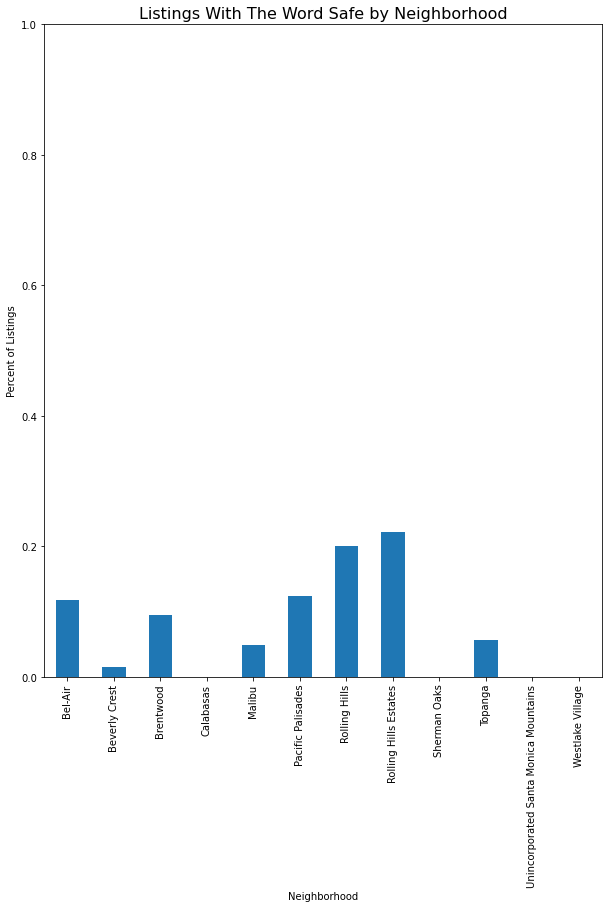

In [101]:
keyword_chart(df_filtered,'safe')

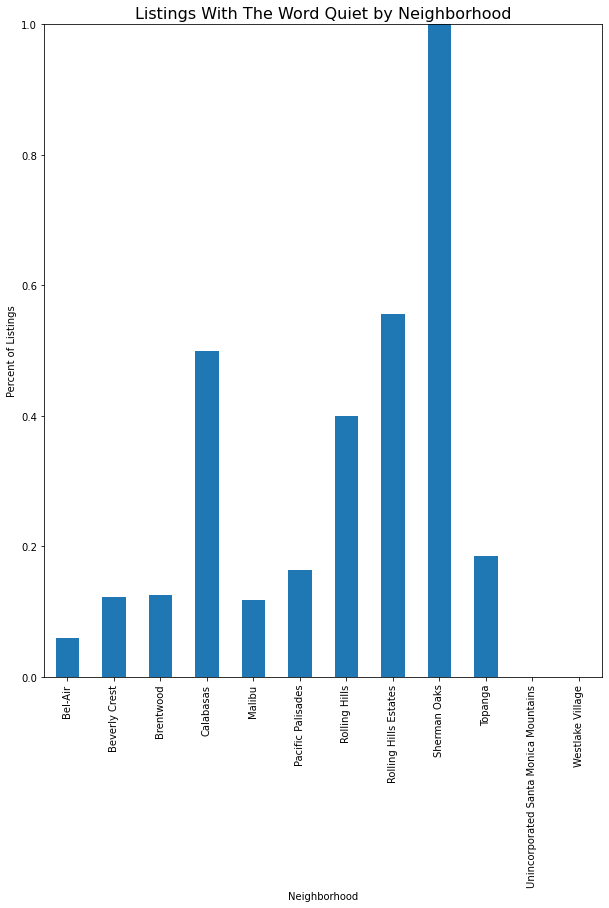

In [102]:
keyword_chart(df_filtered,'quiet')

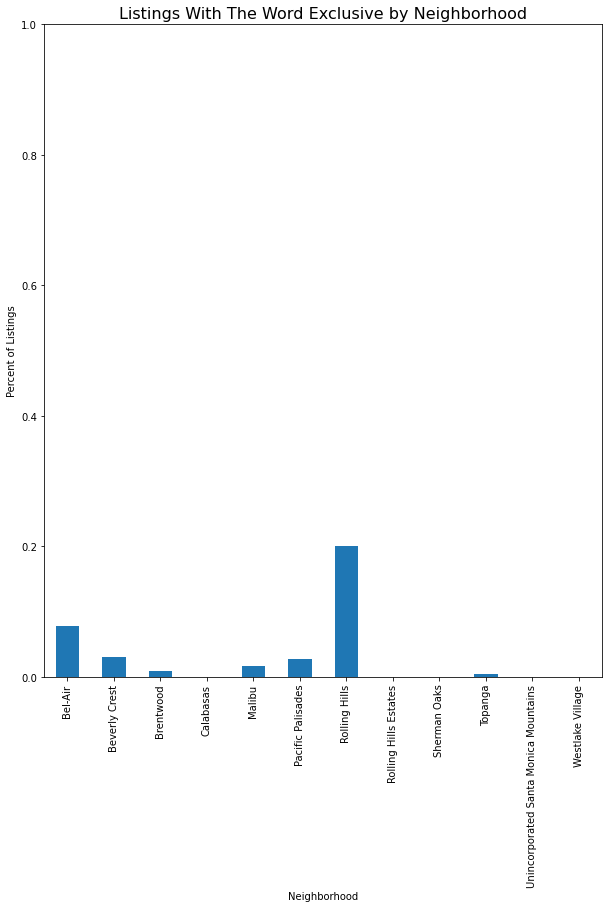

In [103]:
keyword_chart(df_filtered,'exclusive')

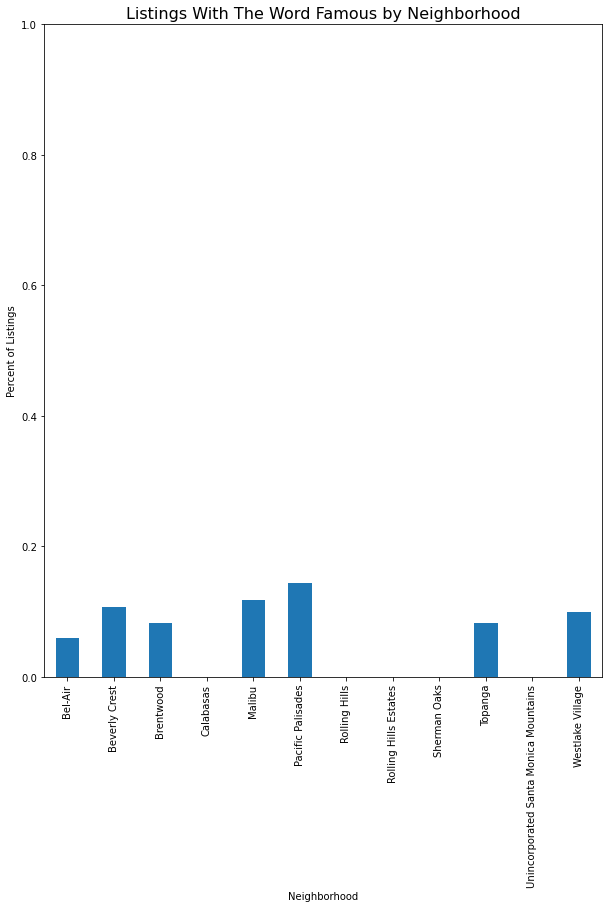

In [73]:
keyword_chart(df_filtered,'famous')

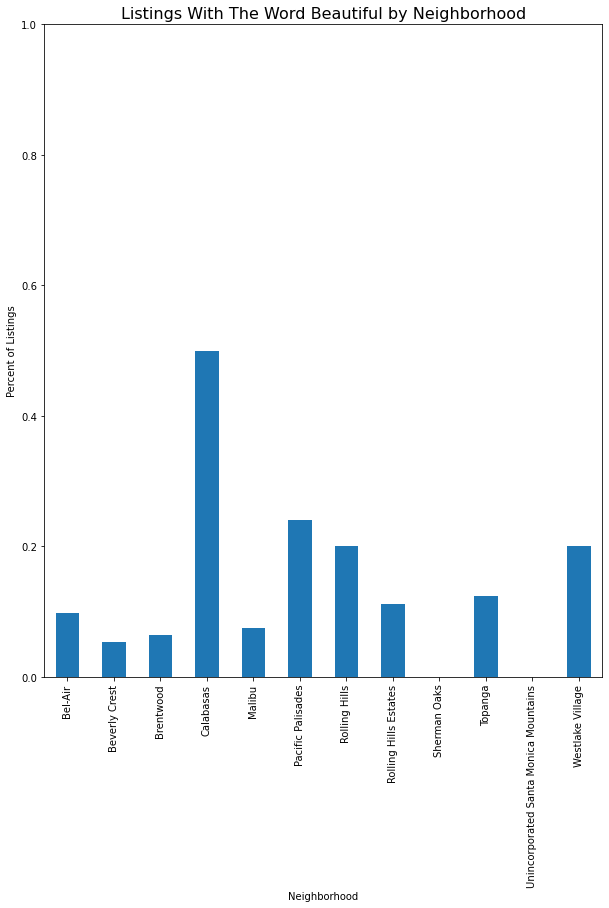

In [74]:
keyword_chart(df_filtered,'beautiful')

## Neighborhood Amenities

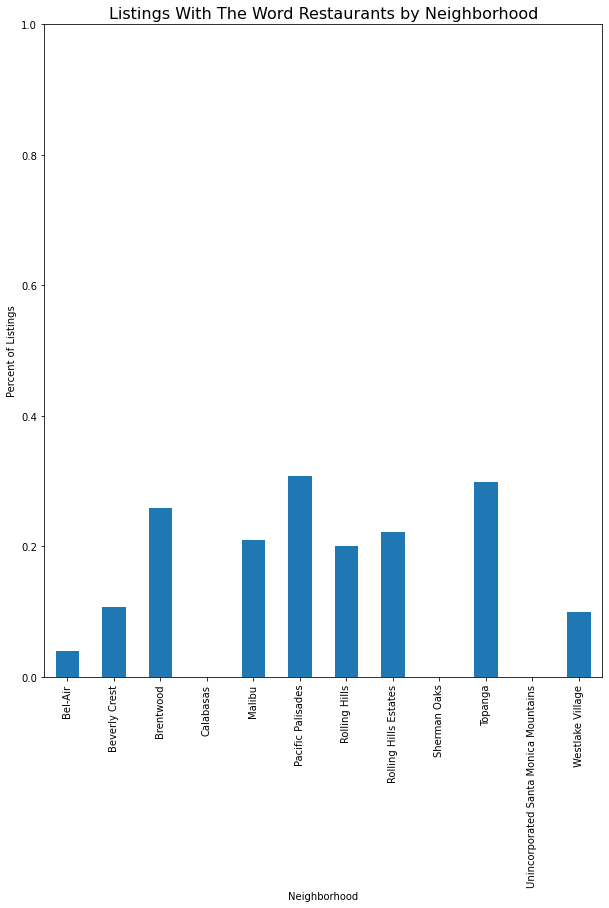

In [75]:
keyword_chart(df_filtered,'restaurants')

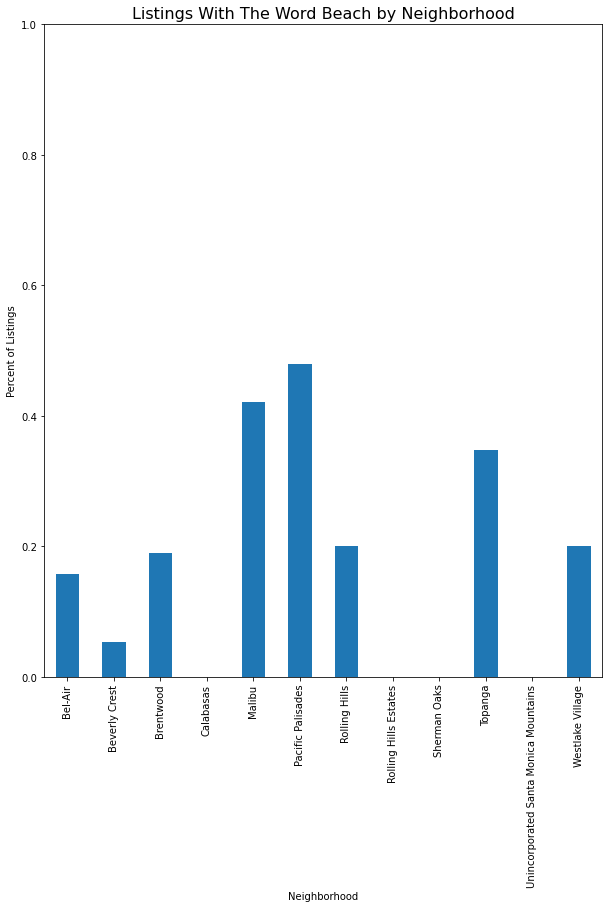

In [76]:
keyword_chart(df_filtered,'beach') 

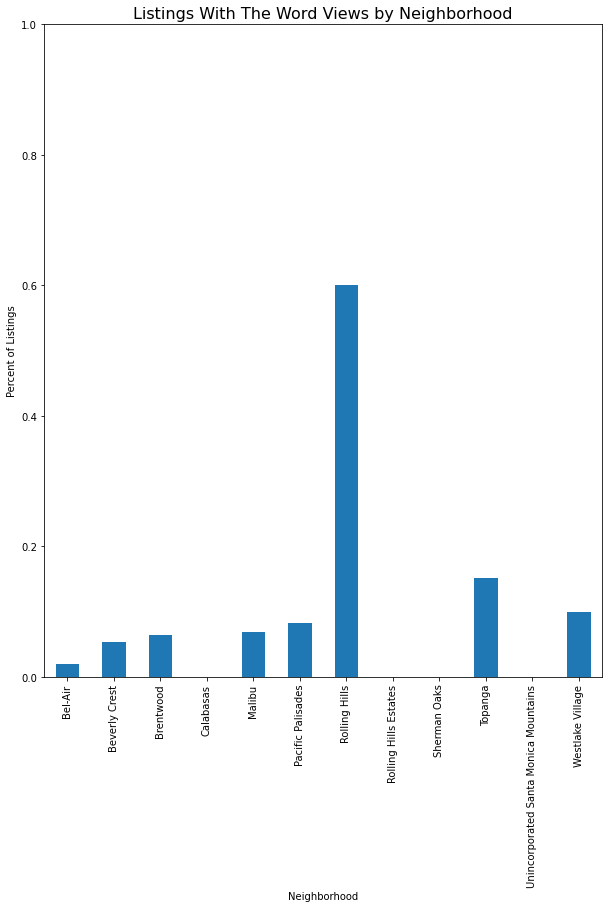

In [77]:
keyword_chart(df_filtered,'views') 

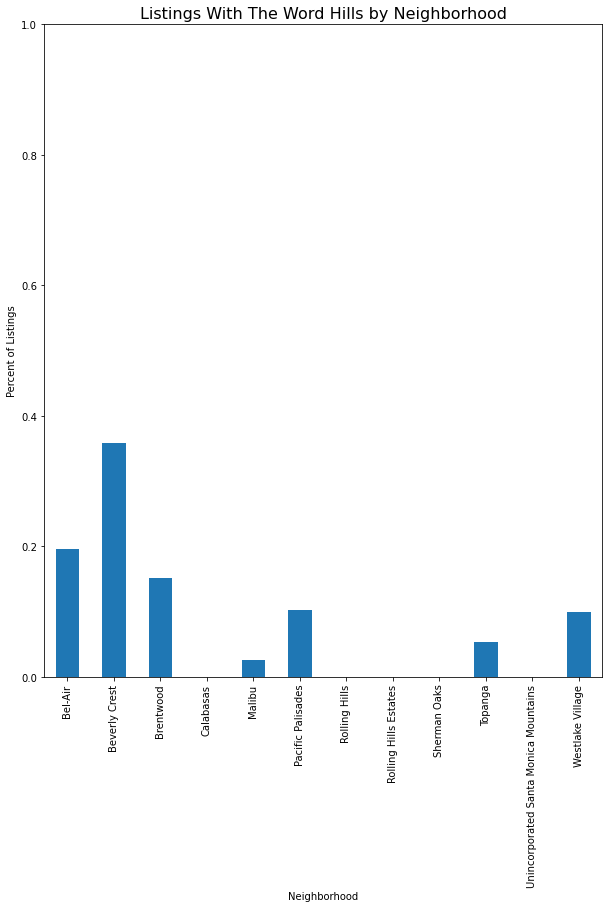

In [78]:
keyword_chart(df_filtered,'hills')

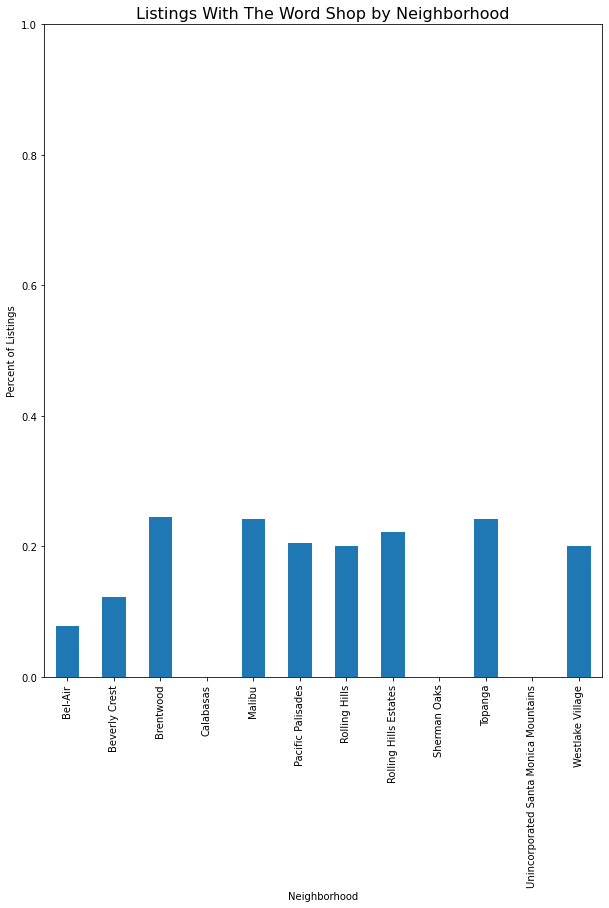

In [79]:
keyword_chart(df_filtered,'shop') 

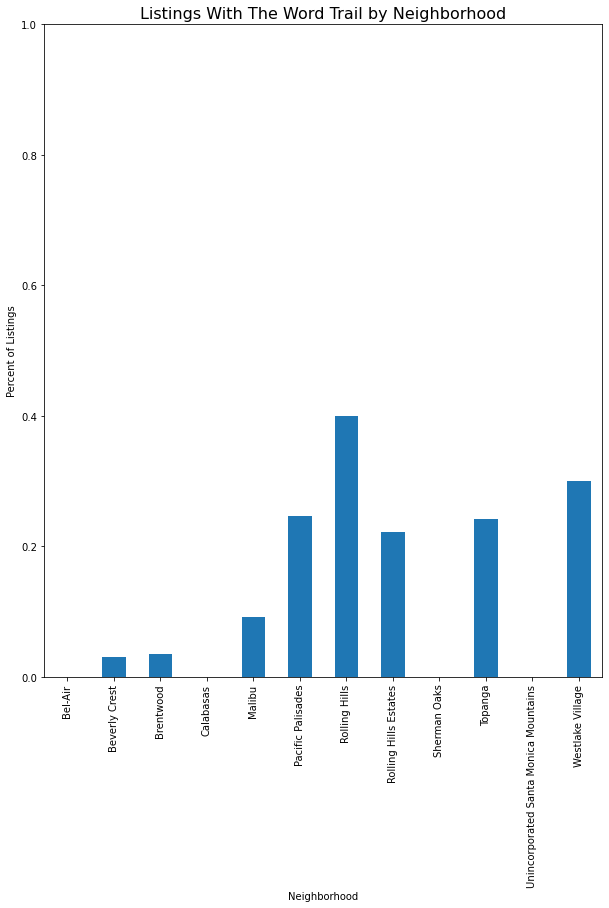

In [80]:
keyword_chart(df_filtered,'trail') 

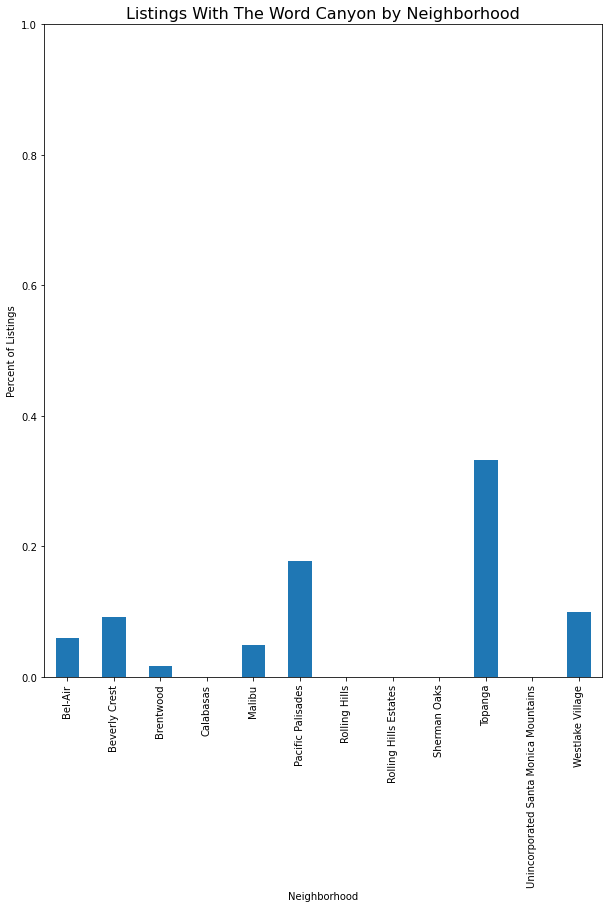

In [81]:
keyword_chart(df_filtered,'canyon')

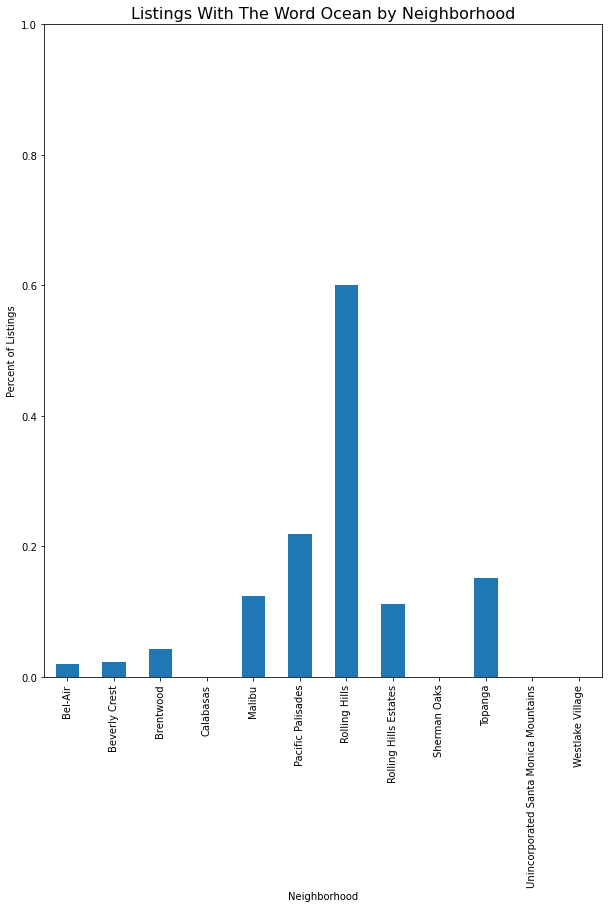

In [82]:
keyword_chart(df_filtered,'ocean') 

## Mobility

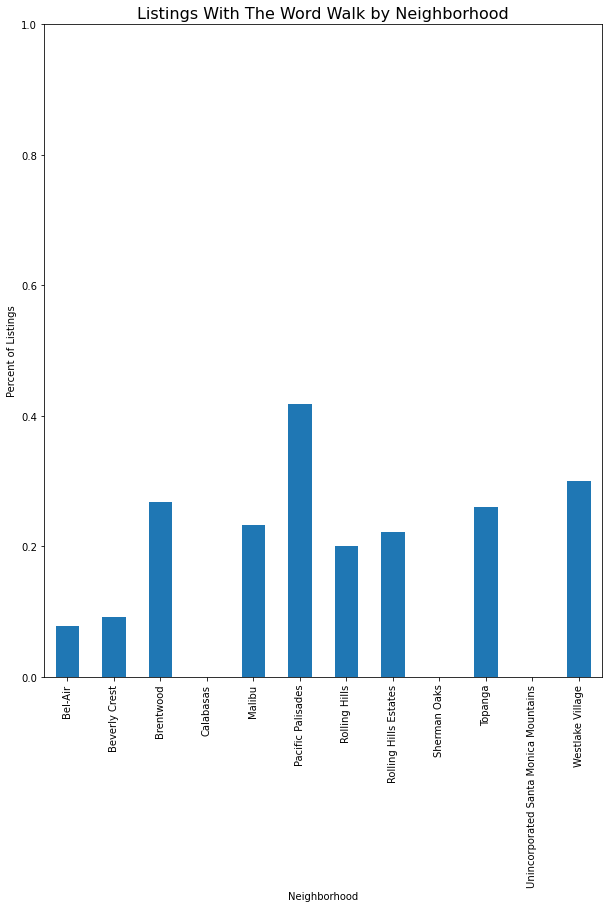

In [83]:
keyword_chart(df_filtered,'walk')

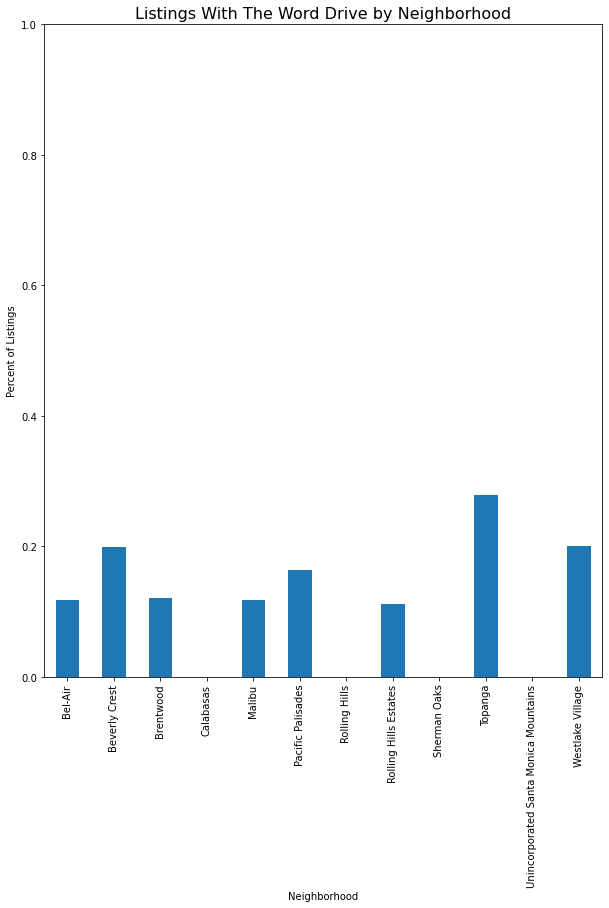

In [84]:
keyword_chart(df_filtered,'drive')

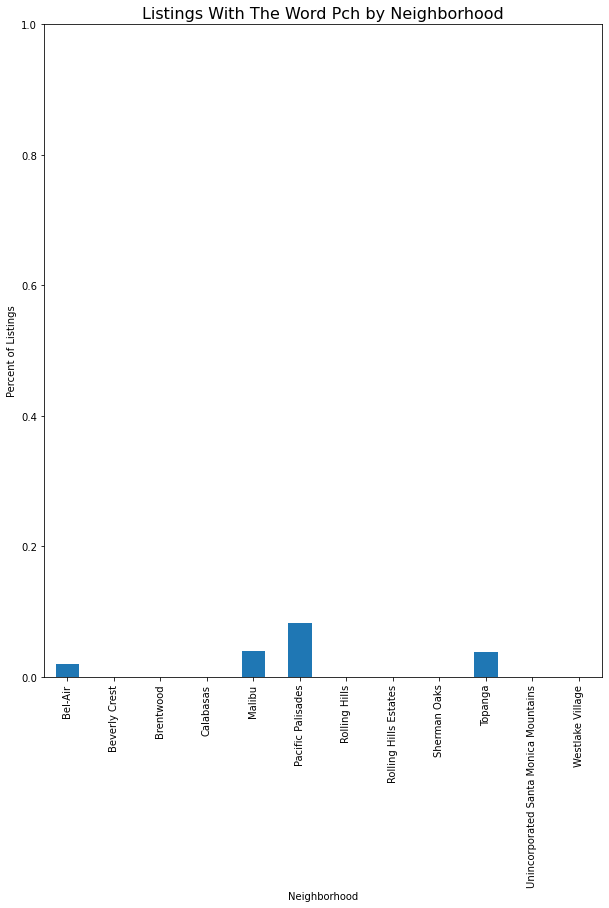

In [85]:
keyword_chart(df_filtered,'pch')

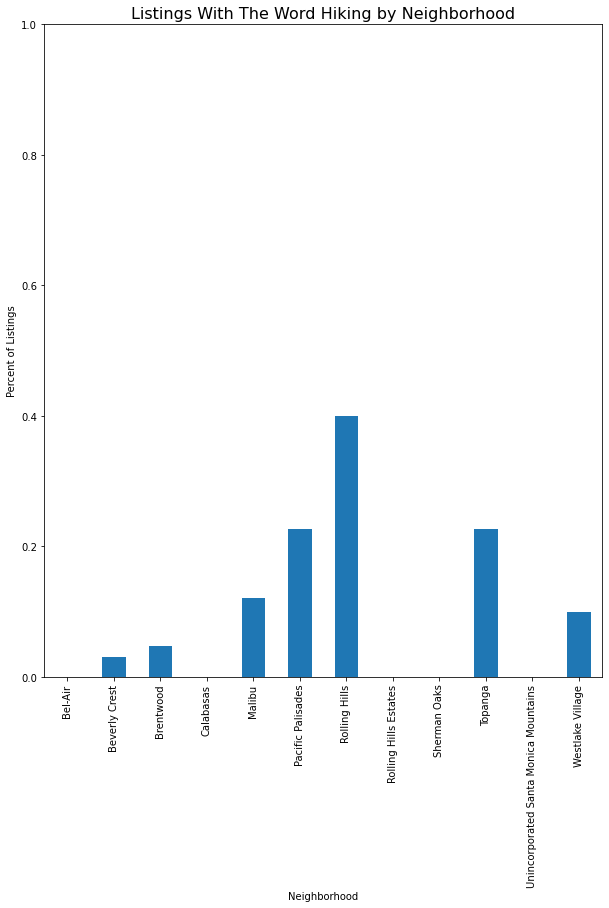

In [92]:
keyword_chart(df_filtered,'hiking')